In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pymc as pm
import arviz as az
import seaborn as sns
import itertools

from scipy.special import logit, expit
from scipy.stats import bernoulli, norm, t, skewnorm
from matplotlib import pyplot as plt
from time import time

from modeltools import plot_prior_postrr, create_summary_stat, mcmc_diagnostics 
from downcast import downcast_df

In [2]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

In [46]:
# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids["topic"].astype(np.int16)

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [4]:
data

,corpus_id,model_id,cordel_id,topic_id,rater_id,intrusion,confidence
0,0,0,0,0,0,1,1
1,0,0,0,0,1,1,1
2,0,0,0,0,6,0,1
3,0,0,0,0,8,1,1
4,0,0,0,0,19,1,1
...,...,...,...,...,...,...,...
12193,1,2,5,49,289,1,1
12194,1,2,5,49,302,1,1
12195,1,2,5,49,303,1,1
12196,1,2,5,49,312,1,1


In [5]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

## Comparing model with/without cordel mean

In [6]:
# Model and MCMC specifications

n_cores = 2
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1t

In [7]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}

glm_rater_topic = {"model":pm.Model()}
glm_rater_topic_cordel = {"model":pm.Model()}


In [8]:
# Rater, Topic model

glm_rater_topic["model"] = pm.Model()
with glm_rater_topic["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1), 
                              dims="obs_id")
    
    glm_rater_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 163 seconds.


In [9]:
# Rater, Topic, Cordel model

glm_rater_topic_cordel["model"] = pm.Model()
with glm_rater_topic_cordel["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                              dims="obs_id")
    
    glm_rater_topic_cordel["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 152 seconds.


## Diagnostics

In [10]:
glm = glm_rater_topic_cordel
glm

{'model': sigma_r ~ Exp(f())
      zr ~ N(0, 1)
 sigma_a ~ Exp(f())
      za ~ N(0, 1)
      mu ~ N(1.1, 1)
  c_mean ~ Deterministic(f(mu, sigma_a, za))
       s ~ Bern(f(sigma_r, zr, mu, sigma_a, za)),
 'trace': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data
 	> constant_data}

In [11]:
summary_stat = create_summary_stat(glm["trace"])

In [12]:
# mcmc_diagnostics(glm["trace"], summary_stat)

In [13]:
summary_stat[(summary_stat["param"]!="za") & (summary_stat["param"]!="zr")]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
621,mu,0,1.5432,0.2175,1.1039,1.9159,0.0135,0.0095,261.2261,503.5044,1.0175
622,mu,1,0.8541,0.2044,0.4372,1.2137,0.0121,0.0087,284.2683,531.8252,1.0114
623,mu,2,1.3002,0.2081,0.9460,1.7117,0.0116,0.0082,321.0428,632.7239,1.0033
624,mu,3,1.4666,0.2032,1.0893,1.8424,0.0116,0.0082,311.7181,669.4373,0.9995
625,mu,4,1.1719,0.2136,0.7504,1.5512,0.0141,0.0100,229.2035,304.4293,1.0086
626,mu,5,1.3115,0.2073,0.9068,1.6893,0.0116,0.0082,322.4432,576.6801,1.0074
627,sigma_r,NaN,0.5083,0.0350,0.4425,0.5737,0.0012,0.0009,813.6462,1472.1398,1.0018
628,sigma_a,NaN,1.3806,0.0697,1.2571,1.5123,0.0034,0.0024,423.9040,769.6923,1.0016
629,c_mean,0,0.7659,0.0105,0.7467,0.7857,0.0003,0.0002,1734.9668,1519.0735,0.9999
630,c_mean,1,0.6407,0.0117,0.6201,0.6638,0.0003,0.0002,1781.2127,1583.9333,0.9995


In [14]:
with glm["model"]:
    glm["prior_sim"]=pm.sample_prior_predictive(1_000)
    glm["postrr_sim"]=pm.sample_posterior_predictive(glm["trace"])
# plot_prior_postrr(glm["prior_sim"], glm["postrr_sim"], data)

/tmp/ipykernel_9424/2250795519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left[["cordel", "topic"]] = left["param_num"].str.split(", ", expand=True)
/tmp/ipykernel_9424/2250795519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left[["cordel", "topic"]] = left["param_num"].str.split(", ", expand=True)
/tmp/ipykernel_9424/2250795519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

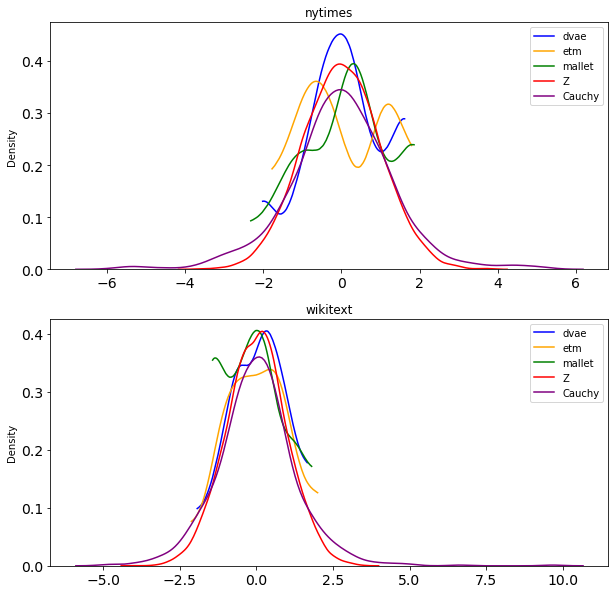

In [15]:
# Plot distribution of topic location params
left = summary_stat[summary_stat["param"]=="za"]
left[["cordel", "topic"]] = left["param_num"].str.split(", ", expand=True)
left["cordel"] = left["cordel"].astype(int)
left["topic"] = left["topic"].astype(int)

test = pd.merge(left, cordel_ids, left_on="cordel", right_on="cordel_id", how="left")

corpora = {"nytimes":"-", "wikitext":"-"}
models = {"dvae":"blue", "etm":"orange", "mallet":"green", "Z":"red", "Cauchy":"purple"}

fig, axs = plt.subplots(2, 1, figsize=(10,10))

for i, corpus in enumerate(corpora):
    for model in models:
        az.plot_kde(np.array(test[(test["corpus"]==corpus) & (test["model"]==model)]["mean"]), ax=axs[i])
        axs[i].get_lines()[-1].set_linestyle(corpora[corpus])
        axs[i].get_lines()[-1].set_color(models[model])
    sns.kdeplot(norm.rvs(0, 1, size=10_000), ax=axs[i], color=models["Z"])
    sns.kdeplot(t.rvs(5, size=1_000), ax=axs[i], color=models["Cauchy"])
    axs[i].set_title(corpus)
    axs[i].legend(axs[i].get_lines(), models.keys())

[]

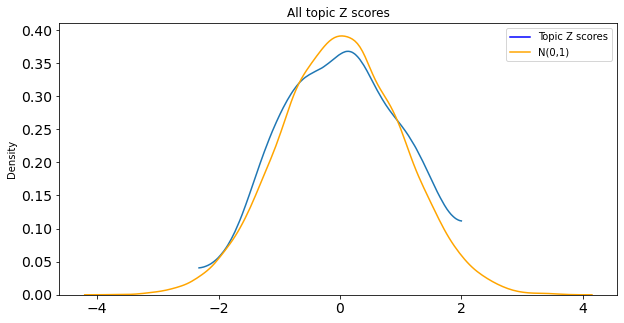

In [16]:
_, ax = plt.subplots(1, 1, figsize=(10,5))
az.plot_kde(np.array(test["mean"]))
sns.kdeplot(norm.rvs(0, 1, size=10_000), color="orange")
ax.set_title("All topic Z scores")
ax.legend(axs[i].get_lines(), ["Topic Z scores", "N(0,1)"])
plt.plot()
# topic scores are fairly normal.

In [17]:
print(test["mean"].min(), test["mean"].max())

-2.3269 2.0041


## Checking topic distributions

In [18]:
# Creating summary stats
summary_stat_ncordel=create_summary_stat(glm_rater_topic["trace"])
summary_stat_cordel=create_summary_stat(glm_rater_topic_cordel["trace"])

topics_ncordel = summary_stat_ncordel[summary_stat["param"]=="za"]
topics_ncordel[["cordel", "topic"]] = topics_ncordel["param_num"].str.split(", ", expand=True)

topics_cordel = summary_stat_cordel[summary_stat["param"]=="za"]
topics_cordel[["cordel", "topic"]] = topics_cordel["param_num"].str.split(", ", expand=True)

/tmp/ipykernel_9424/376362390.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  topics_ncordel = summary_stat_ncordel[summary_stat["param"]=="za"]
/tmp/ipykernel_9424/376362390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_ncordel[["cordel", "topic"]] = topics_ncordel["param_num"].str.split(", ", expand=True)
/tmp/ipykernel_9424/376362390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_ncordel[["cordel", "topic"]] = topics_ncordel["param_num"].str.sp

In [19]:
# What is the mean z-scores of topics without cordel mean
topics_ncordel.groupby("cordel").agg({"mean":"mean"})

,mean
cordel,
0,0.173578
1,-0.272160
2,0.020242
3,0.131460
4,-0.070316
5,0.016906


In [20]:
# What is the mean z-scores of topics with cordel mean
topics_cordel.groupby("cordel").agg({"mean":"mean"})
# Looks like the mean of the z values is approximately 0

,mean
cordel,
0,0.005866
1,0.007876
2,0.007020
3,0.013430
4,0.000930
5,-0.001796


In [21]:
# What are the point estimates for cordel means?
summary_stat_cordel[summary_stat_cordel["param"]=="mu"]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
621,mu,0,1.5432,0.2175,1.1039,1.9159,0.0135,0.0095,261.2261,503.5044,1.0175
622,mu,1,0.8541,0.2044,0.4372,1.2137,0.0121,0.0087,284.2683,531.8252,1.0114
623,mu,2,1.3002,0.2081,0.9460,1.7117,0.0116,0.0082,321.0428,632.7239,1.0033
624,mu,3,1.4666,0.2032,1.0893,1.8424,0.0116,0.0082,311.7181,669.4373,0.9995
625,mu,4,1.1719,0.2136,0.7504,1.5512,0.0141,0.0100,229.2035,304.4293,1.0086
626,mu,5,1.3115,0.2073,0.9068,1.6893,0.0116,0.0082,322.4432,576.6801,1.0074


In [22]:
# Check: What would the cordel means be from no cordel model.
topics_ncordel.groupby("cordel").agg({"mean":"mean"}) \
* summary_stat_ncordel[summary_stat_ncordel["param"]=="sigma_a"]["mean"].iloc[0]\
+ summary_stat_ncordel[summary_stat_ncordel["param"]=="mu"]["mean"].iloc[0]

,mean
cordel,
0,1.524439
1,0.904952
2,1.311332
3,1.465903
4,1.185475
5,1.306696


<AxesSubplot:title={'center':'zr'}, ylabel='Density'>

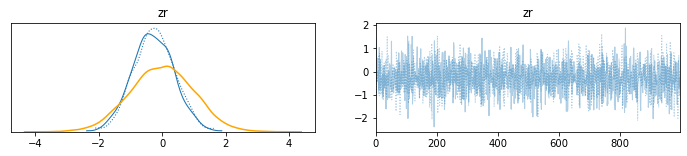

In [23]:
# Traces are not normal distributed
a = az.plot_trace(glm_rater_topic_cordel["trace"].posterior, coords = {"zr_dim_0":5}, var_names="zr")[0]
sns.kdeplot(norm.rvs(0,1,size=10_000), ax=a[0], color="orange")

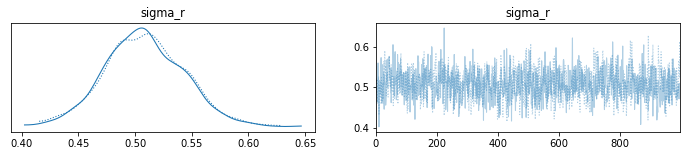

In [24]:
a = az.plot_trace(glm_rater_topic_cordel["trace"].posterior, var_names="sigma_r")

In [25]:
corpus_raters={}
corpus_raters[0]=data[data["corpus_id"]==0]["rater_id"].unique()
corpus_raters[1]=data[data["corpus_id"]==1]["rater_id"].unique()

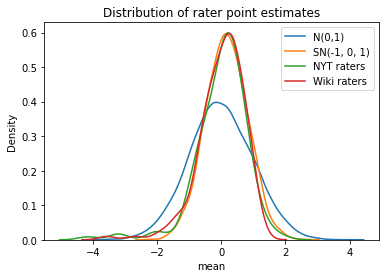

In [26]:
_, ax = plt.subplots(1, 1, figsize=(6,4))
ss0 = summary_stat[(summary_stat["param"]=="zr")&(summary_stat["param_num"].isin((str(i) for i in corpus_raters[0])))]
ss1 = summary_stat[(summary_stat["param"]=="zr")&(summary_stat["param_num"].isin((str(i) for i in corpus_raters[1])))]
sns.kdeplot(norm.rvs(0, 1, size=10_000), ax=ax)
sns.kdeplot(skewnorm.rvs(0.3, loc=0, scale=0.68, size=10_000), ax=ax)
sns.kdeplot(ss0["mean"], ax=ax)
sns.kdeplot(ss1["mean"], ax=ax)
ax.legend(ax.get_lines(), ["N(0,1)", "SN(-1, 0, 1)", "NYT raters", "Wiki raters"])
ax.set_title("Distribution of rater point estimates")
plt.show()


# Distribution of rater point estimates is not standard normal. 
# It is left skewed (aka a few people are terrible at intrusion scores)
# Select which raters and then use their posteriors to generate

In [27]:
summary_stat["param"].value_counts()

zr         321
za         300
c_mean       6
mu           6
sigma_a      1
sigma_r      1
Name: param, dtype: int64

## Simulating Rater/Topic Interactions

In [99]:
p_diff = 0.08
n_sim_raters = 40
topics_per_r = 40
n_sims = 1_000
seed = 1992


# Setting numpy seed
np.random.seed(seed)

# Adding cordel id to topic_ids dataframe
topic_cordel_ids = pd.merge(topic_ids, cordel_ids, on=["corpus", "model"], how="left")

In [100]:
ps_data = pd.DataFrame(columns=["sim_id", "sim_cordel_id", "sim_topic_id", "sim_rater_id", 
                                "cordel_id", "topic_id", "rater_id"], dtype=np.int16)
start = time()

for sim_id in range(n_sims):

    # data template
    sim_data = pd.DataFrame(columns=["sim_id", "cordel_id", "topic_id", "rater_id"])  
    
    # Raters in this simulation
    raters = np.random.choice(data["rater_id"].unique(), size=n_sim_raters, replace=True)

    
    # Topics in this simulation (topic_cordel_ids index values)
    sim_topics = np.random.choice(range(len(topic_cordel_ids)), size=100, replace=True)
    sim_cordel0_topics = sim_topics[:50]
    sim_cordel1_topics = sim_topics[50:]

    # Count of scores for each topic
    counts = np.zeros(100)

    for sim_rater_id, rater in enumerate(raters):
    #     Set the probability. Topics with fewer samples have higher probability
        counts = counts-counts.min()+1
        p = 1/counts**20
        p = p/p.sum()

    #     Sample according to probability
        rated_topics = np.random.choice(range(100), size=topics_per_r, replace=False, p=p)
        rated_topics_idx = sim_topics[rated_topics]
        counts[rated_topics] += 1

    #     Append topics to simulation
        d=topic_cordel_ids.loc[rated_topics_idx, ["topic_id", "cordel_id"]]
        d["sim_rater_id"]=sim_rater_id
        d["sim_topic_id"]=rated_topics
        d["rater_id"]=rater

        sim_data = pd.concat([sim_data, d], axis="rows", ignore_index=True)

#     Adding one topic/rater interaction into df
    sim_data["sim_id"] = sim_id
    sim_data.loc[sim_data["sim_topic_id"].isin(range(0,50)),["sim_cordel_id"]] = 0
    sim_data.loc[sim_data["sim_topic_id"].isin(range(50,100)),["sim_cordel_id"]] = 1
#     sim_data = pd.merge(sim_data, topic_counts[["cordel_id", "topic_id", "sim_cordel_id"]]
#                         ,on=["cordel_id", "topic_id"], how="left")
    sim_data=sim_data.astype(np.int16)

#     Appending interaction to ds.
    ps_data = pd.concat([ps_data, sim_data], ignore_index=True)
    
    if sim_id % 100 == 0:
        print(f"sim_id {sim_id}: {time() - start:.2f}s")

sim_id 0: 0.20s
sim_id 100: 12.33s
sim_id 200: 24.13s
sim_id 300: 36.31s
sim_id 400: 48.39s
sim_id 500: 60.61s
sim_id 600: 73.89s
sim_id 700: 87.21s
sim_id 800: 100.88s
sim_id 900: 113.60s


In [101]:
d = ps_data.copy(deep=True)

[]

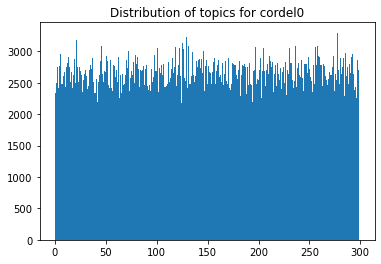

In [102]:
d["topic_idx"] = d["cordel_id"]*np.array([50]) + d["topic_id"]
plt.hist(d[d["sim_cordel_id"]==0]["topic_idx"], bins=300)
plt.title("Distribution of topics for cordel0")
plt.plot()

[]

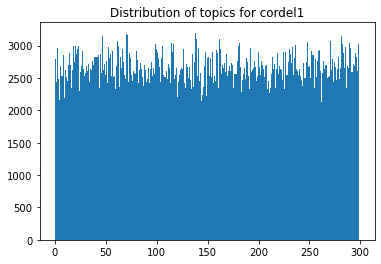

In [103]:
d["topic_idx"] = d["cordel_id"]*np.array([50]) + d["topic_id"]
plt.hist(d[d["sim_cordel_id"]==1]["topic_idx"], bins=300)
plt.title("Distribution of topics for cordel1")
plt.plot()

[]

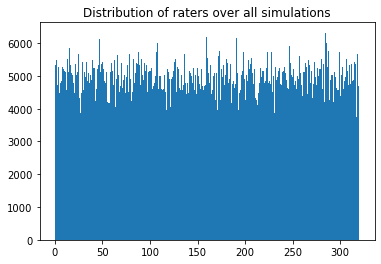

In [104]:
plt.hist(d["rater_id"], bins=d["rater_id"].nunique())
plt.title("Distribution of raters over all simulations")
plt.plot()

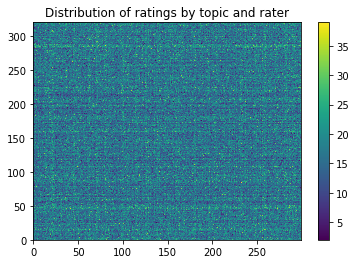

In [105]:
fig, ax = plt.subplots()
hh = ax.hist2d(d["topic_idx"], d["rater_id"],bins=[300, d["rater_id"].nunique()])
fig.colorbar(hh[3], ax=ax)
plt.title("Distribution of ratings by topic and rater")
plt.show()

## Simulating Scores

In [106]:
pymc_model = glm_rater_topic_cordel["model"]
trace = glm_rater_topic_cordel["trace"]

# Calculating proposed logodds means
# https://www.wolframalpha.com/input?i=solve+for+x+and+y%2C+x%2By%3Dc%2C+1%2F%281%2Be%5E-x%29-1%2F%281%2Be%5E-y%29%3Dp
mean_model_logodds = summary_stat[summary_stat["param"]=="mu"]["mean"].mean()
c = 2*mean_model_logodds
C = np.exp(-c)
det = p_diff**2-2*C*(p_diff**2-2)+(C**2)*(p_diff**2)
quad = (-p_diff*(C+1)+det**0.5)/(2*(p_diff+1))
proposed_model1_mean = -np.log(quad)
proposed_model0_mean = c-proposed_model1_mean

In [107]:
# Setting trace of cordel 0 and cordel 1 to proposed values
trace.posterior["mu"].loc[dict(mu_dim_0=0)] = proposed_model0_mean
trace.posterior["mu"].loc[dict(mu_dim_0=1)] = proposed_model1_mean

In [108]:
start = time()

sim_scores = pd.DataFrame(columns=["sim_id", "sim_cordel_id", "sim_topic_id", "sim_rater_id", "cordel_id", "topic_id", "rater_id", "intrusion", ]
                       ,dtype=np.int16)
# TODO: add chain options
for sim_id in range(1_000):
    # Setting data containing rater/topic interaction
    sim_data = ps_data[ps_data["sim_id"]==sim_id]
    sim_rater_array = np.array(sim_data["rater_id"], dtype=int)
    topic_array = np.array([sim_data["cordel_id"], sim_data["topic_id"]], dtype=int)
    cordel_array = np.array(sim_data["sim_cordel_id"], dtype=int)
    
    # Running simulation
    with pymc_model:
        pm.set_data({
            "raters":sim_rater_array, 
            "topics":topic_array, 
            "cordels":cordel_array})
        postrr_sim=pm.sample_posterior_predictive(trace.posterior.sel({"chain":[0], "draw":[sim_id]})
                                                  ,predictions=True, progressbar=False, random_seed=seed+sim_id)
    
    # Adding results to sim_scores
    s = (postrr_sim.predictions.to_dataframe().reset_index()
          .rename(columns={"s":"intrusion"}))
    this_sim_scores = pd.concat([sim_data.reset_index(drop=True)
                                 ,s["intrusion"]], axis="columns").astype(np.int16)
    sim_scores = pd.concat([sim_scores, this_sim_scores], axis="index", ignore_index=True)
    
    if sim_id % 100 == 0:
        print(f"sim_id {sim_id}: {time() - start:.2f}s")
print(f"done! {time() - start:.2f}s")

sim_id 0: 0.10s
sim_id 100: 9.32s
sim_id 200: 17.51s
sim_id 300: 25.43s
sim_id 400: 35.07s
sim_id 500: 43.92s
sim_id 600: 52.64s
sim_id 700: 60.82s
sim_id 800: 69.60s
sim_id 900: 79.21s
done! 87.17s


Perc of simulations with mean1 < mean0 (n raters=40): 8.4%


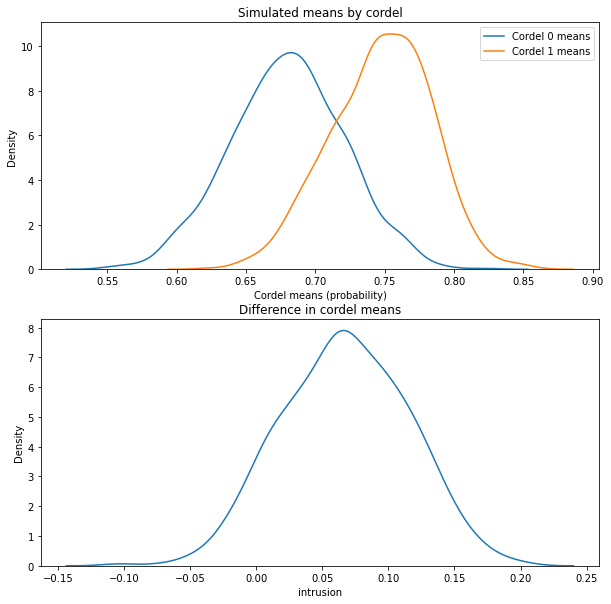

In [109]:
_, ax = plt.subplots(2,1,figsize=(10,10))

n_ratings_per_cordel = n_sim_raters*topics_per_r/2

sns.kdeplot(sim_scores[sim_scores["sim_cordel_id"]==0].groupby(["sim_id"]).agg({"intrusion":"sum"})["intrusion"]/n_ratings_per_cordel, ax=ax[0])
sns.kdeplot(sim_scores[sim_scores["sim_cordel_id"]==1].groupby(["sim_id"]).agg({"intrusion":"sum"})["intrusion"]/n_ratings_per_cordel, ax=ax[0])
ax[0].legend(ax[0].get_lines(), ["Cordel 0 means", "Cordel 1 means"])
ax[0].set_xlabel("Cordel means (probability)")
ax[0].set_title(f"Simulated means by cordel")

diff = sim_scores[sim_scores["sim_cordel_id"]==1].groupby(["sim_id"]).agg({"intrusion":"sum"}) \
        - sim_scores[sim_scores["sim_cordel_id"]==0].groupby(["sim_id"]).agg({"intrusion":"sum"})

sns.kdeplot(diff["intrusion"]/n_ratings_per_cordel, ax=ax[1])
ax[1].set_title(f"Difference in cordel means")
plt.plot()

print(f"Perc of simulations with mean1 < mean0 (n raters={n_sim_raters}): {(diff['intrusion']<=0).sum()/1000:.1%}")


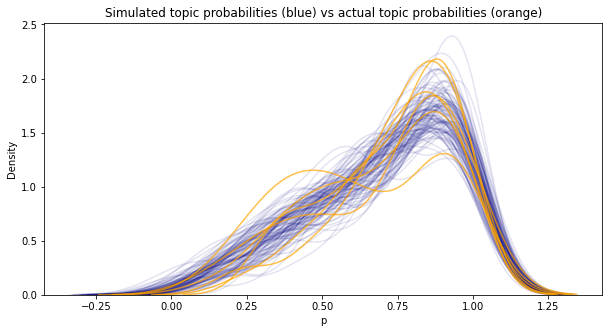

In [110]:
size=100

_, ax = plt.subplots(1,1,figsize=(10,5))


# Selecting 100 random simulations
rand_ids = np.random.choice(range(1000), size=size, replace=False)

# Calculating topic proportions
samples = (sim_scores[sim_scores["sim_id"].isin(rand_ids)].groupby(["sim_id", "sim_topic_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
samples["p"] = samples[("intrusion", "sum")]/samples[("intrusion", "count")]
# Plotting proportions
for sim_id in rand_ids:
    sns.kdeplot(samples[samples["sim_id"]==sim_id]["p"], ax=ax, color="navy", alpha=7/size**0.9)

# Repeat calculations and plots for actual data
actuals = (data.groupby(["cordel_id", "topic_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
actuals["p"]=actuals[("intrusion", "sum")]/actuals[("intrusion", "count")]
for cordel_id in range(6):
    sns.kdeplot(actuals[actuals["cordel_id"]==cordel_id]["p"], ax=ax, color="orange", alpha=0.7)

ax.set_title("Simulated topic probabilities (blue) vs actual topic probabilities (orange)")
plt.show()

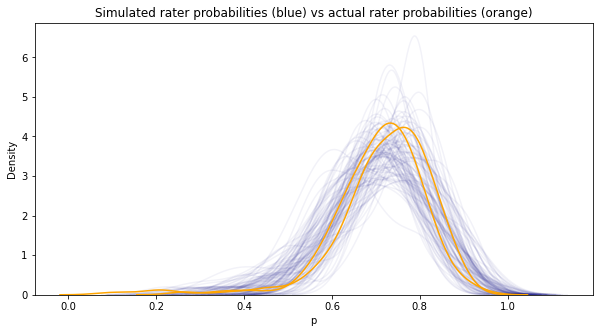

In [111]:
size=100

_, ax = plt.subplots(1,1,figsize=(10,5))


# Selecting 100 random simulations
rand_ids = np.random.choice(range(1000), size=size, replace=False)

# Calculating rater proportions
samples = (sim_scores[sim_scores["sim_id"].isin(rand_ids)].groupby(["sim_id", "sim_rater_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
samples["p"] = samples[("intrusion", "sum")]/samples[("intrusion", "count")]
# Plotting proportions
for sim_id in rand_ids:
    sns.kdeplot(samples[samples["sim_id"]==sim_id]["p"], ax=ax, color="navy", alpha=0.05)

# Repeat calculations and plots for actual data
actuals = (data.groupby(["corpus_id", "rater_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
actuals["p"]=actuals[("intrusion", "sum")]/actuals[("intrusion", "count")]
for corpus_id in range(2):
    sns.kdeplot(actuals[actuals["corpus_id"]==corpus_id]["p"], ax=ax, color="orange", alpha=1)

ax.set_title("Simulated rater probabilities (blue) vs actual rater probabilities (orange)")
plt.show()

. \
. \
. \
. \
. \
. \
. 
## Simulating Scores (Archive)

In [18]:
p_diff = 0.08 #Hoyle set the difference as 4/50 topics
corpus = "nytimes"
# Proposed mean of model 0 has worse performance, Proposed mean of model 1 has better performance 
model0 = "dvae"
model1 = "etm"
n_sim_raters = 20
topics_per_r = 40

# Setting up dataframe
topics = summary_stat[summary_stat["param"]=="za"]
topics[["cordel", "topic"]] = topics["param_num"].str.split(", ", expand=True)

# Fetching model ids
cordel0 = cordel_ids[
    (cordel_ids["model"]==model0) & 
    (cordel_ids["corpus"]==corpus)
]["cordel_id"].item()
cordel1  = cordel_ids[
    (cordel_ids["model"]==model1) & 
    (cordel_ids["corpus"]==corpus)
]["cordel_id"].item()

/tmp/ipykernel_4584/289123916.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics[["cordel", "topic"]] = topics["param_num"].str.split(", ", expand=True)
/tmp/ipykernel_4584/289123916.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics[["cordel", "topic"]] = topics["param_num"].str.split(", ", expand=True)


In [19]:
# Fetching means and simgas
mu = summary_stat[summary_stat["param"]=="mu"]["mean"].item()
sigma_a = summary_stat[summary_stat["param"]=="sigma_a"]["mean"].item()

model0_mean = mu + sigma_a*topics[(topics["cordel"]==str(cordel0))]["mean"].mean()
model1_mean = mu + sigma_a*topics[(topics["cordel"]==str(cordel1))]["mean"].mean()

# Calculating proposed means
# https://www.wolframalpha.com/input?i=solve+for+x+and+y%2C+x%2By%3Dc%2C+1%2F%281%2Be%5E-x%29-1%2F%281%2Be%5E-y%29%3Dp
c = (model0_mean + model1_mean)
C = np.exp(-c)
det = p_diff**2-2*C*(p_diff**2-2)+(C**2)*(p_diff**2)
quad = (-p_diff*(C+1)+det**0.5)/(2*(p_diff+1))
proposed_model1_mean = -np.log(quad)
proposed_model0_mean = c-proposed_model1_mean

# Add diff to all trace values
model0_mean_diff = (proposed_model0_mean-model0_mean)/sigma_a
model1_mean_diff = (proposed_model1_mean-model1_mean)/sigma_a

# Changing trace values by the difference between proposed and measured means
proposed_trace = glm_rater_topic["trace"].copy()
proposed_trace.posterior["za"].loc[{"za_dim_0":cordel0}] += model0_mean_diff
proposed_trace.posterior["za"].loc[{"za_dim_0":cordel1}] += model1_mean_diff

ValueError: can only convert an array of size 1 to a Python scalar

In [18]:
# Sampling raters and topics ------------------------------
unique_raters={}
unique_raters["nytimes"] = data[data["corpus_id"]==0]["rater_id"].unique()
unique_raters["wikitext"] = data[data["corpus_id"]==1]["rater_id"].unique()

ps_data = pd.DataFrame(columns=["cordel_id", "topic_id", "rater_id"])

# Generate 20 random topics per model per rater 
raters = np.random.choice(unique_raters[corpus], size=n_sim_raters, replace=False)
for rater in raters:
#     Set the probability. Topics with fewer samples have higher probability
    p0 = 1/ps_data[ps_data["cordel_id"]==cordel0]["topic_id"].value_counts().sort_index()**10
    p0 = np.array(p0/p0.sum())
    p1 = 1/ps_data[ps_data["cordel_id"]==cordel1]["topic_id"].value_counts().sort_index()**10
    p1 = np.array(p1/p1.sum())
    
    try:
        topics0 = np.random.choice(data[data["cordel_id"]==cordel0]["topic_id"].unique(), 
                                   size=topics_per_r//2, replace=False, p=p0)
        topics1 = np.random.choice(data[data["cordel_id"]==cordel1]["topic_id"].unique(),
                                   size=topics_per_r//2, replace=False, p=p1)
    except ValueError:
        topics0 = np.random.choice(data[data["cordel_id"]==cordel0]["topic_id"].unique(), 
                                   size=topics_per_r//2, replace=False)
        topics1 = np.random.choice(data[data["cordel_id"]==cordel1]["topic_id"].unique(),
                                   size=topics_per_r//2, replace=False)
    df0=pd.DataFrame(topics0, columns=["topic_id"])
    df1=pd.DataFrame(topics1, columns=["topic_id"])   
    df0["rater_id"]=rater
    df1["rater_id"]=rater
    df0["cordel_id"]=cordel0
    df1["cordel_id"]=cordel1
    ps_data = pd.concat([ps_data, df0, df1], axis="rows", ignore_index=True)

In [37]:
# Creating NP arrays
sim_rater_array = np.array(ps_data["rater_id"], dtype=int)
sim_topic_array = np.array([ps_data["cordel_id"], ps_data["topic_id"]], dtype=int)
sim_cordel_array = np.array(ps_data["cordel_id"], dtype=int)

In [20]:
# Simulating scores
with glm_rater_topic["model"]:
    pm.set_data({
        "raters":ps_rater_array, 
        "topics":ps_topic_array, 
        "cordels":ps_cordel_array})
    postrr_sim=pm.sample_posterior_predictive(proposed_trace, predictions=True)

[]

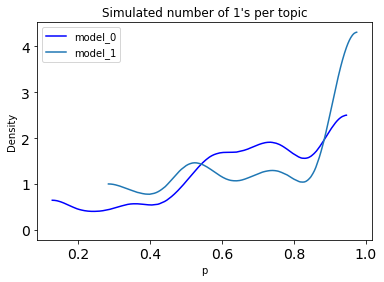

In [21]:
# Plotting simulated score distributions ------------------------------
target="s"
postrr_samples = postrr_sim.predictions.sel(chain=0)

# Manipulating samples to plot
df_postrr, na_s = downcast_df(postrr_samples[target].to_dataframe().reset_index())

# Joining rater/topic/model/corpus information
data1 = ps_data.copy()
data1["obs_id"] = data1.index
df_postrr1 = pd.merge(df_postrr, data1, on="obs_id", how="left")

# Aggregating "1s" and counts by topic
postrr_agg0 = df_postrr1[df_postrr1["cordel_id"]==0].groupby("topic_id").agg({target:["sum", "count"]}).reset_index()
postrr_agg1 = df_postrr1[df_postrr1["cordel_id"]==1].groupby("topic_id").agg({target:["sum", "count"]}).reset_index()
                                                             
# Calculating topic probabilities from sums and counts
postrr_topic_prob0 = postrr_agg0[("s","sum")]/postrr_agg0[("s","count")]
postrr_topic_prob1 = postrr_agg1[("s","sum")]/postrr_agg1[("s","count")]

# Setting up plot
ax = az.plot_kde(np.array(postrr_topic_prob0), bw=0.05)
ax.get_lines()[0].set_color("orange")
ax = az.plot_kde(np.array(postrr_topic_prob1), bw=0.05)
ax.get_lines()[0].set_color("blue")
ax.legend(ax.get_lines(), ["model_0", "model_1"])
ax.set_title("Simulated number of 1's per topic")
ax.set_ylabel("Density")
ax.set_xlabel("p")
plt.plot()

[]

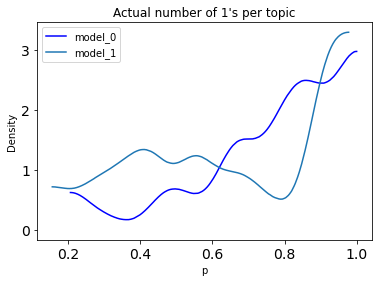

In [22]:
# Plotting actual score distributions ------------------------------
model0obs = data[data["cordel_id"]==0].groupby("topic_id").agg({"intrusion":["sum","count"]})
model1obs = data[data["cordel_id"]==1].groupby("topic_id").agg({"intrusion":["sum","count"]})

# Calculating topic probabilities from sums and counts
model0p = model0obs[("intrusion","sum")]/model0obs[("intrusion","count")]
model1p = model1obs[("intrusion","sum")]/model1obs[("intrusion","count")]

# Setting up plot
ax = az.plot_kde(np.array(model0p), bw=0.05)
ax.get_lines()[0].set_color("orange")
ax = az.plot_kde(np.array(model1p), bw=0.05)
ax.get_lines()[0].set_color("blue")
ax.legend(ax.get_lines(), ["model_0", "model_1"])
ax.set_title("Actual number of 1's per topic")
ax.set_ylabel("Density")
ax.set_xlabel("p")
plt.plot()

In [23]:
print(f"model 0 proposed mean:{proposed_model0_mean}, actual mean:{model0_mean}")
print(f"model 1 proposed mean:{proposed_model1_mean}, actual mean:{model1_mean}")

model 0 proposed mean:0.991162005301534, actual mean:1.5274225644000001
model 1 proposed mean:1.4455807748984664, actual mean:0.9093202158


## Topic Model Difference Inference

In [25]:
chain = 0
draw = 0

In [40]:
sim_scores_array = np.array(postrr_sim.predictions.loc[{"chain":chain, "draw":draw}]["s"])

In [83]:
# Rater, Topic model

with pm.Model() as simulated_model:
    # Hyperparameter priors
    sim_raters = pm.Data("raters", sim_rater_array, mutable=False, dims="obs_id")
    sim_topics = pm.Data("topics", sim_topic_array, mutable=False, dims=["cordel", "topic"])
    sim_cordels = pm.Data("cordels", sim_cordel_array, mutable=False, dims="obs_id")
    sim_scores = pm.Data("scores", sim_scores_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[sim_topics[0],sim_topics[1]]*sigma_a+
                zr[sim_raters]*sigma_r),
            observed=sim_scores, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1), 
                              dims="obs_id")
    
    diff = pm.Deterministic("diff", 
                            pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1)[cordel1]-
                            pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1)[cordel0])
    
    sim_trace=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.


In [85]:
sim_summary_stat[sim_summary_stat["param"]=="c_mean"]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
624,c_mean,0,0.9934,0.0039,0.9861,0.9994,0.0001,0.0001,2042.5300,1888.7443,0.9992
625,c_mean,1,0.0074,0.0043,0.0009,0.0152,0.0001,0.0001,2095.0029,1858.8748,1.0005
626,c_mean,2,0.5203,0.0721,0.3929,0.6636,0.0018,0.0013,1600.6043,1341.8270,0.9993
627,c_mean,3,0.5168,0.0682,0.3863,0.6395,0.0017,0.0012,1619.9936,1336.5753,1.0001
628,c_mean,4,0.5212,0.0698,0.3900,0.6499,0.0019,0.0013,1336.6375,1483.3362,1.0071
629,c_mean,5,0.5209,0.0704,0.3913,0.6563,0.0017,0.0012,1732.8051,1507.3171,1.0008


In [86]:
az.summary(sim_trace, var_names=["diff"], 
           stat_funcs={"alpha":lambda x:np.percentile(x, 0.05)}
          )["alpha"].item()

-0.998

In [88]:
def accept_model_diff(model, sim_scores_array):
    with model:
        pm.set_data({"scores":sim_scores_array})
        sim_trace=pm.sample(cores=n_cores)
    test_stat = az.summary(sim_trace, var_names=["diff"], 
           stat_funcs={"alpha":lambda x:np.percentile(x, 0.05)}
          )["alpha"].item()
    print(f"{test_stat=}")
    return test_stat > 0

In [90]:
sim_scores_array = 1-sim_cordel_array
accept_model_diff(simulated_model, sim_scores_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.


-0.998


False

## Putting it all together

In [ ]:
# trial_record
sim_id
cordel0
cordel1
p_diff
n_sim_rater
topics_per_r
chain
draw
diff

# score_record
sim_id
cordel
topic
rater
score

In [ ]:
topics_per_r = 40

for p_diff in [0.04, 0.06, 0.08, 0.1, 0.15]:
    for cordel0, cordel1 in cordels:
        Set n_sim_raters = bayes_opt.next_param_value()
            Generate posterior predictive
            for trial in 50 random trials wo replacement (chain 0):
                calculate test statistic
                record results
            bayes_opt.feed_statistic(abs(45 - no_accepts))
        # n_sim_raters has been approximately found
        Set n_sim_raters = bayes_opt.next_param_value(range=)
            Generate posterior predictive
            for trial in 200 random trials wo replacement (chain 0):
                calculate test statistic
                record results
            bayes_opt.feed_statistic(abs(200 - no_accepts))
        return least n_sim_raters such that statistic>180

In [15]:
# Parameters

p_diff = 0.08 #Hoyle set the difference as 4/50 topics
corpus = "nytimes"
# Proposed mean of model 0 has smaller p, Proposed mean of model 1 has larger p 
model0 = "dvae"
model1 = "etm" 
n_sim_raters = 20
topics_per_r = 40

def p_model_diff(model, sim_scores_array):
    with model:
        pm.set_data({"scores":sim_scores_array})
        sim_trace=pm.sample(cores=n_cores)
    test_stat = az.summary(sim_trace, var_names=["diff"], 
           stat_funcs={"alpha":lambda x:np.percentile(x, 0.05)}
          )["alpha"].item()
    return test_statistic

In [17]:
# Setting up dataframe
topics = summary_stat[summary_stat["param"]=="za"]
topics[["cordel", "topic"]] = topics["param_num"].str.split(", ", expand=True)

# Fetching model ids
cordel0 = cordel_ids[
    (cordel_ids["model"]==model0) & 
    (cordel_ids["corpus"]==corpus)
]["cordel_id"].item()
cordel1  = cordel_ids[
    (cordel_ids["model"]==model1) & 
    (cordel_ids["corpus"]==corpus)
]["cordel_id"].item()

# Fetching sigma and mean for topics by cordel
mu = summary_stat[summary_stat["param"]=="mu"]["mean"].item()
sigma_a = summary_stat[summary_stat["param"]=="sigma_a"]["mean"].item()

model0_mean = mu + sigma_a*topics[(topics["cordel"]==str(cordel0))]["mean"].mean()
model1_mean = mu + sigma_a*topics[(topics["cordel"]==str(cordel1))]["mean"].mean()

# Calculating proposed topic means
# https://www.wolframalpha.com/input?i=solve+for+x+and+y%2C+x%2By%3Dc%2C+1%2F%281%2Be%5E-x%29-1%2F%281%2Be%5E-y%29%3Dp
c = (model0_mean + model1_mean)
C = np.exp(-c)
det = p_diff**2-2*C*(p_diff**2-2)+(C**2)*(p_diff**2)
quad = (-p_diff*(C+1)+det**0.5)/(2*(p_diff+1))
proposed_model1_mean = -np.log(quad)
proposed_model0_mean = c-proposed_model1_mean

# Finding the difference in proposed and observed means
model0_mean_diff = (proposed_model0_mean-model0_mean)/sigma_a
model1_mean_diff = (proposed_model1_mean-model1_mean)/sigma_a

# Changing trace values by the difference
proposed_trace = glm_rater_topic["trace"].copy()
proposed_trace.posterior["za"].loc[{"za_dim_0":cordel0}] += model0_mean_diff
proposed_trace.posterior["za"].loc[{"za_dim_0":cordel1}] += model1_mean_diff

# Sampling raters and topics ------------------------------
unique_raters={}
unique_raters["nytimes"] = data[data["corpus_id"]==0]["rater_id"].unique()
unique_raters["wikitext"] = data[data["corpus_id"]==1]["rater_id"].unique()

ps_data = pd.DataFrame(columns=["cordel_id", "topic_id", "rater_id"])

# Generate 20 random topics per model per rater 
raters = np.random.choice(unique_raters[corpus], size=n_sim_raters, replace=False)
for rater in raters:
    p0 = 1/ps_data[ps_data["cordel_id"]==cordel0]["topic_id"].value_counts().sort_index()**10
    p0 = np.array(p0/p0.sum())
    p1 = 1/ps_data[ps_data["cordel_id"]==cordel1]["topic_id"].value_counts().sort_index()**10
    p1 = np.array(p1/p1.sum())
    
    try:
        topics0 = np.random.choice(data[data["cordel_id"]==cordel0]["topic_id"].unique(), 
                                   size=topics_per_r//2, replace=False, p=p0)
        topics1 = np.random.choice(data[data["cordel_id"]==cordel1]["topic_id"].unique(),
                                   size=topics_per_r//2, replace=False, p=p1)
    except ValueError:
        topics0 = np.random.choice(data[data["cordel_id"]==cordel0]["topic_id"].unique(), 
                                   size=topics_per_r//2, replace=False)
        topics1 = np.random.choice(data[data["cordel_id"]==cordel1]["topic_id"].unique(),
                                   size=topics_per_r//2, replace=False)
    df0=pd.DataFrame(topics0, columns=["topic_id"])
    df1=pd.DataFrame(topics1, columns=["topic_id"])   
    df0["rater_id"]=rater
    df1["rater_id"]=rater
    df0["cordel_id"]=cordel0
    df1["cordel_id"]=cordel1
    ps_data = pd.concat([ps_data, df0, df1], axis="rows", ignore_index=True)
    
# Creating NP arrays
sim_rater_array = np.array(ps_data["rater_id"], dtype=int)
sim_topic_array = np.array([ps_data["cordel_id"], ps_data["topic_id"]], dtype=int)
sim_cordel_array = np.array(ps_data["cordel_id"], dtype=int)
    
# Simulating scores
with glm_rater_topic["model"]:
    pm.set_data({
        "raters":sim_rater_array, 
        "topics":sim_topic_array, 
        "cordels":sim_cordel_array})
    ps_sim=pm.sample_posterior_predictive(proposed_trace, predictions=True)

/tmp/ipykernel_12276/3471460761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics[["cordel", "topic"]] = topics["param_num"].str.split(", ", expand=True)
/tmp/ipykernel_12276/3471460761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics[["cordel", "topic"]] = topics["param_num"].str.split(", ", expand=True)


In [20]:
# Defining model to fit simulated data
sim_scores_array = np.array(ps_sim.predictions.loc[{"chain":0, "draw":0}]["s"])
with pm.Model() as simulated_model:
    # Hyperparameter priors
    sim_raters = pm.Data("raters", sim_rater_array, mutable=False, dims="obs_id")
    sim_topics = pm.Data("topics", sim_topic_array, mutable=False, dims=["cordel", "topic"])
    sim_cordels = pm.Data("cordels", sim_cordel_array, mutable=False, dims="obs_id")
    sim_scores = pm.Data("scores", sim_scores_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[sim_topics[0],sim_topics[1]]*sigma_a+
                zr[sim_raters]*sigma_r),
            observed=sim_scores, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1), 
                              dims="obs_id")
    
    diff = pm.Deterministic("diff", 
                            pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1)[cordel1]-
                            pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1)[cordel0])


In [22]:
for chain, draw in itertools.product(range(2), range(10)):
    sim_scores_array = np.array(ps_sim.predictions.loc[{"chain":chain, "draw":draw}]["s"])
    p_model_diff(simulated_model, sim_scores_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


test_stat=-0.06
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


test_stat=-0.058
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7034, but should be close to 0.8. Try to increase the number of tuning steps.


test_stat=-0.074
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


test_stat=-0.022
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


test_stat=-0.037
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


test_stat=-0.017
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


test_stat=-0.067
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


test_stat=-0.078
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


test_stat=-0.031
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


test_stat=-0.05
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


test_stat=-0.021
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


test_stat=-0.062
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


test_stat=-0.053
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


test_stat=-0.045
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


test_stat=-0.017
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


test_stat=-0.046
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


test_stat=-0.014
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7091, but should be close to 0.8. Try to increase the number of tuning steps.


test_stat=-0.004
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


test_stat=-0.012
False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


test_stat=-0.027
False
